# Pipeline for the personalization validation (TCGA prostate data, Montagud Analysis)

In [1]:
import pandas as pd
import numpy as np 
import os
import ast
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests


from functions.validation_utils.validation_pers import pre_process_data_validation, create_pers_models_generic
from functions.analysis_utils.MaBoSS_simulation.maboss_phenotype_patient import compute_phenotype_table, compute_phenotype_mean_group_validation

from functions.analysis_utils.MaBoSS_simulation.maboss_phenotype_patient import collect_group_data
from functions.analysis_utils.stats.stats_proba import compute_kruskal_test_means


from functions.validation_utils.analysis_validation import validation_analysis


In [2]:
type_models = 'genes_proteins_models' # 'genes_models' or 'proteins_models'

folder_model_original = 'data/montagud_models'

folder_results = f'analysis/validation/{type_models}/results'
folder_validation = f'analysis/validation/{type_models}' # models

os.makedirs(folder_results, exist_ok=True)
os.makedirs(folder_validation, exist_ok=True)

### Loading the datasets

In [3]:
# Loading the data

phenotype_data = pd.read_csv('data/TCGA_data/prostate/TCGA_PRAD_phenotypes.csv')
genes_data = pd.read_csv('data/TCGA_data/prostate/TCGA_PRAD_genes_illumina.csv', sep='\t')
cnv_data = pd.read_csv('data/TCGA_data/prostate/TCGA_PRAD_cnv_gistic2.csv',sep='\t')
genes_synonyms = pd.read_csv('data/e_ensembl/genes_synonyms.csv', delimiter="\t")
uniprot_data = pd.read_csv('data/uniprot/uniprot_map.csv')
proteins_data = pd.read_csv('data/TCGA_data/prostate/TCGA_PRAD_proteins_RPPA.csv',sep='\t')

montagud_data = (
    pd.read_csv('data/Montagud_inter_nodes_data.csv', header=1)
    .loc[:, ['Target node', 'Interaction type', 'Source']])

name_montagud_maps = {
        "CASPASE8": "CASP8",
        "CASPASE3": "CASP3",
        "CASPASE9": "CASP9",
        "CYCLINB": "CCNB1",
        "CYCLIND": "CCND1",
        "DSH": "DVL1",
        "BETA_CATENIN": "CTNNB1",
        "E_CADHERIN": "CDH1",
        "CYCC": "CYCS",
        "MEK1_2": "MEK1",
        "NF_KB": "NFKB",
        "SNAIL": "SNAI1",
        "TNFALPHA": "TNF",
        "TSC1_2": "TSC1",
        "BCL_XL": "BCL2L1",
        "MAP3K1_3": "MAP3K1",
        "CHK1_2": "CHK1",
}


nodes_to_add = ['MEK2', 'TSC2', 'MAP3K3', 'CHK2']

# proteins synonyms 
proteins_synonyms_maps = {
        "RAF1": "RAF",
        "BCL2L2": "BCL2",
        "SMAD1": "SMAD",
        "SMAD3": "SMAD",
        "SMAD4": "SMAD",
        "SMAD5": "SMAD",
        "BAK1": "BAK",
        "GSK3A": "GSK3",
        "GSK3B": "GSK3",
        "TGFBR2": "TGFBR",
        "TGFBR3": "TGFBR",
        "NRAS": "RAS",
        "KRAS": "RAS",
        "HRAS": "RAS",
        "AKT2": "AKT",
        "MYCN": "MYC",
        }



tissue = 'Prostate'


# Inputs
inputs_list = ['EGF', 'FGF', 'TGFB', 'ANDROGEN', 'HYPOXIA', 'NUTRIENTS', 'CARCINOGEN', 'ACIDOSIS', 'TNF', 'SPOP']


# Phenotypes
phenotype_interest = ["PROLIFERATION","INVASION","DNA_REPAIR","MIGRATION","APOPTOSIS"]


# size of each group of patients
size_group = 30

### Pre-processing datasets
- Create groups based on gleason score (low, middle, high)
- Filter genes, cnv to keep only genes/ proteins of montagud nodes

In [4]:
patients_groups, patients_id,montagud_nodes,df_melted_gene,table_rna_seq_patients,df_melted_cnv,df_melted_protein,table_proteins_patients = pre_process_data_validation(size_group,phenotype_data,cnv_data, montagud_data, name_montagud_maps,nodes_to_add, genes_data, proteins_data, proteins_synonyms_maps)


low_groups_patients = list(patients_groups[patients_groups['Gleason_group'] == 'low_aggressive']['sampleID'])
middle_groups_patients = list(patients_groups[patients_groups['Gleason_group'] == 'middle_aggressive']['sampleID'])
high_groups_patients = list(patients_groups[patients_groups['Gleason_group'] == 'high_aggressive']['sampleID'])

/Users/romane/repos/icr/Attractor-Resistance/functions/validation_utils/validation_pers.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnv_data_filtered["Gene Symbol"] = cnv_data_filtered["Gene Symbol"].apply(
/Users/romane/repos/icr/Attractor-Resistance/functions/validation_utils/validation_pers.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes_data_filtered["sample"] = genes_data_filtered["sample"].apply(
/Users/romane/repos/icr/Attractor-Resistance/functions/generate_utils/pre_process_dat

In [5]:
intersection = set(low_groups_patients) & set(middle_groups_patients) & set(high_groups_patients)
print(intersection)

set()


### Create personalized Prostate models (genes/ proteins and CNV)

In [6]:
# Read the two processed data

original_model_cfg = f'{folder_model_original}/Montagud2022_Prostate_Cancer.cfg'
original_model_bnd = f'{folder_model_original}/Montagud2022_Prostate_Cancer.bnd'

os.makedirs(folder_validation, exist_ok=True)


# create_pers_models_generic(
#     folder_validation,
#     original_model_cfg,
#     original_model_bnd,
#     patients_id,
#     tissue,
#     name_montagud_maps,
#     type_models,
#     phenotype_interest,
#     patients_groups,
#     montagud_nodes,
#     df_melted_gene,
#     df_melted_cnv,
#     table_rna_seq_patients,
#     df_melted_protein,
#     table_proteins_patients,
#     context_label = tissue
#     )



### Analysis of attractors distribution

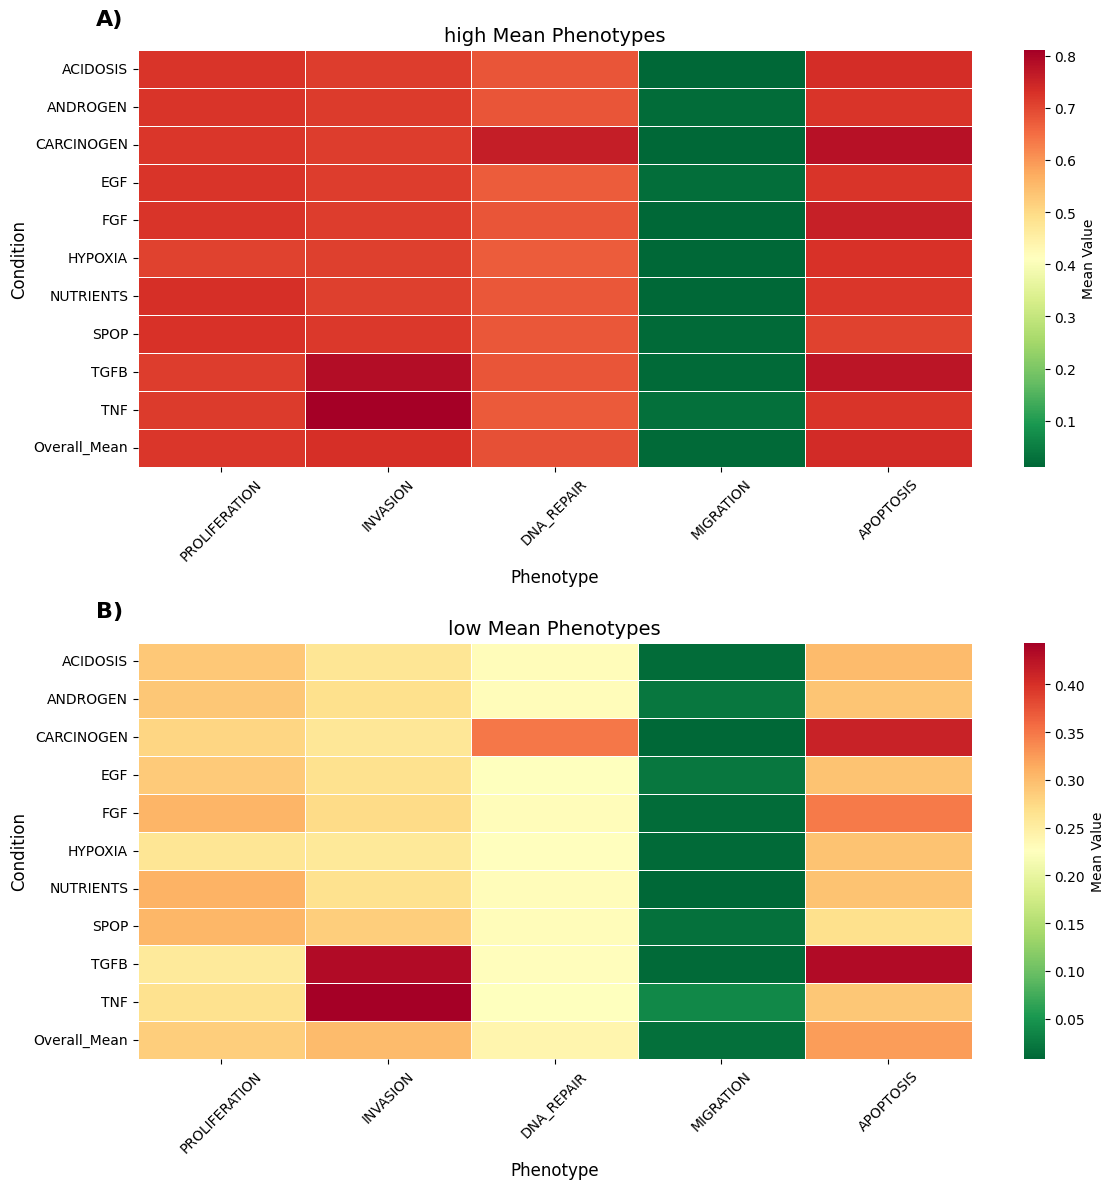

/Users/romane/repos/icr/Attractor-Resistance/functions/analysis_utils/stats/stats_proba.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(ast.literal_eval)
/Users/romane/repos/icr/Attractor-Resistance/functions/analysis_utils/stats/stats_proba.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(ast.literal_eval)
/Users/romane/repos/icr/Attractor-Resistance/functions/analysis_utils/stats/stats_proba.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(ast.literal_eval)


In [7]:

groups = ["low_aggressive", "middle_aggressive", "high_aggressive"]

adjusted_df = validation_analysis(
    folder_results,
    folder_validation,
    patients_id,
    patients_groups,
    inputs_list,
    phenotype_interest,
    groups,
    tissue,
    type_models,
    group_categories=groups
)

In [8]:
adjusted_df

(           PROLIFERATION  INVASION DNA_REPAIR MIGRATION APOPTOSIS
 EGF             0.011178  0.011443   0.011601  0.287096  0.007608
 FGF              0.03054  0.007608   0.027213  0.436898  0.006293
 TGFB            0.027213  0.003819   0.009718  0.235527  0.007443
 ANDROGEN        0.027213  0.003819     0.0165  0.367477  0.006293
 HYPOXIA         0.030787  0.009337    0.03054   0.03054  0.027213
 NUTRIENTS       0.016571  0.027213   0.027213   0.07061   0.00912
 CARCINOGEN      0.029011  0.021887   0.016838  0.050559  0.006293
 ACIDOSIS        0.022527  0.003819   0.010808  0.194753  0.003819
 TNF             0.003819  0.003819   0.012386  0.063092  0.011443
 SPOP             0.02652  0.027213    0.03054  0.121092  0.027213,
      Condition      Phenotype Adjusted_P_Value
 0          EGF  PROLIFERATION         0.011178
 1          EGF       INVASION         0.011443
 2          EGF     DNA_REPAIR         0.011601
 4          EGF      APOPTOSIS         0.007608
 5          FGF  PROLI

results 

-> apoptosis better results with proteins than genes

low: almost healthy 

annotations, what sample ? cancerous for sure?


est ce que apoptosis evader ?